# Basic classification using timm and albumentations 

- **timm** It is a collection of pretrained models for computer vision tasks, including:
  *Convolutional Neural Networks (CNNs)*: Use convolution layers to capture local patterns like edges and textures.
*Vision Transformers (ViTs)*: Use self-attention to capture global relationships across an image.
*EfficientNet*: A family of CNNs that scale depth, width, and resolution efficiently for high accuracy with fewer parameters.
*Hybrid Architectures*: Combine CNNs and Transformers to leverage both local and global feature learning.
- **albumentations** A fast and flexible image augmentation library widely used in computer vision.
- Provides geometric transforms: rotations, flips, cropping, scaling, etc.
- Provides photometric transforms: color shifts, brightness/contrast, noise, etc.
- Includes advanced augmentations: blur, cutout, CLAHE (Contrast Limited Adaptive Histogram Equalization), elastic transforms.
- Optimized for speed and efficiency, often faster than PIL/OpenCV on large datasets.


# Binary Classification Problem:
- **Input (x)**: An image represented as real values in shape H × W × C, where
H = Height
W = Width
C = Channels (1 for grayscale, 3 for RGB).
- **Output (y)**: A binary label where
y = 0 → Human/Real Image
y = 1 → AI-Generated Image


In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import timm
import albumentations as albu
from albumentations.pytorch import ToTensorV2

from PIL import Image
import torch
from torch.utils.data import Dataset
import torch.nn as nn
from torch.optim import AdamW, Adam
from torch.optim.lr_scheduler import StepLR

from sklearn.metrics import f1_score
from tqdm import tqdm
import copy

In [2]:
class CustomDataset(Dataset):
    def __init__(self, df, data_dir, transforms=None, is_train=True):
        """
        Args:
            df (pd.DataFrame): DataFrame containing file names and labels.
            data_dir (str): Directory where the image files are stored.
            transforms (albu.Compose, optional): Albumentations transforms to apply to the images.
            is_train (bool, optional): Flag to indicate if the dataset is for training.
        """
        self.df = df
        self.data_dir = data_dir
        self.transforms = transforms
        self.is_train = is_train

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Extract the file name and label
        filename = self.df.iloc[idx]['file_name']
        label = self.df.iloc[idx]['label']

        # Load the image
        img_path = os.path.join(self.data_dir, filename)
        image = Image.open(img_path).convert('RGB')  # Ensure image is in RGB mode
        image = np.array(image)  # Convert to NumPy array (Albumentations requires this format)

        # Apply transforms if specified
        if self.transforms:
            image = self.transforms(image=image)['image']

        # For training, return the image and label
        if self.is_train:
            return image, label
        # For inference, return only the image
        else:
            return image


In [3]:
# Constants - Reduced for quick training
BATCH_SIZE = 32  # Increased batch size for faster training
SEED = 42
IMG_SIZE = 224  # Reduced image size for faster processing
SAMPLE_SIZE = 1000  # Very small sample for quick testing

# Load the train CSV
train_csv_path = "/kaggle/input/ai-vs-human-generated-dataset/train.csv"
train_df = pd.read_csv(train_csv_path)

# Take a very small sample for quick debugging
train_df = train_df.sample(n=SAMPLE_SIZE, random_state=SEED)
print(f"Using {len(train_df)} samples for quick training")

# Define the base directory where images are stored
train_data_dir = "/kaggle/input/ai-vs-human-generated-dataset/"

# Train & validation split
train_df, val_df = train_test_split(
    train_df, test_size=0.3, random_state=SEED, stratify=train_df['label']
)

print(f"Train samples: {len(train_df)}, Validation samples: {len(val_df)}")

# Transformations - Simplified for speed
train_transform = albu.Compose([
    albu.HorizontalFlip(p=0.5),
    albu.Resize(IMG_SIZE, IMG_SIZE),
    albu.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_transform = albu.Compose([
    albu.Resize(IMG_SIZE, IMG_SIZE),
    albu.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

# Dataset and DataLoader
train_dataset = CustomDataset(train_df, train_data_dir, transforms=train_transform, is_train=True)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

# Fixed: Set is_train=True for validation dataset to return labels
val_dataset = CustomDataset(val_df, train_data_dir, transforms=val_transform, is_train=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Test iteration
for images, labels in train_dataloader:
    print("Train batch:", images.shape, labels.shape)
    break

for images, labels in val_dataloader:
    print("Validation batch:", images.shape, labels.shape)
    break


Using 1000 samples for quick training
Train samples: 700, Validation samples: 300
Train batch: torch.Size([32, 3, 224, 224]) torch.Size([32])
Validation batch: torch.Size([32, 3, 224, 224]) torch.Size([32])


In [4]:
# Fixed training configuration
LR = 1e-3  # Much higher learning rate for faster convergence
NUM_EPOCHS = 5  # More epochs to see actual learning

model = timm.create_model('tf_efficientnetv2_s.in21k_ft_in1k', 
                          pretrained=True,
                         num_classes=2)

optimizer = Adam(model.parameters(), lr=LR, weight_decay=1e-4)  # Reduced weight decay
scheduler = StepLR(optimizer, step_size=2, gamma=0.5)  # Less aggressive decay
loss_fn = nn.CrossEntropyLoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model.safetensors:   0%|          | 0.00/86.5M [00:00<?, ?B/s]

Using device: cuda


In [5]:
def train_model_fixed(
    model, train_loader, val_loader, optimizer, scheduler, loss_fn, device, num_epochs=5
):
    model.to(device)
    best_f1 = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    history = {"train_loss": [], "val_loss": [], "val_f1": []}
    
    # Calculate steps per epoch
    steps_per_epoch = len(train_loader)
    eval_every = max(5, steps_per_epoch // 4)  # Evaluate 4 times per epoch, minimum every 5 batches
    
    print(f"Steps per epoch: {steps_per_epoch}")
    print(f"Will evaluate every {eval_every} batches")
    
    global_step = 0
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        print("-" * 50)
        
        # Training phase
        model.train()
        epoch_loss = 0.0
        epoch_correct = 0
        epoch_total = 0
        
        for batch_idx, (images, labels) in enumerate(tqdm(train_loader, desc="Training")):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # Track metrics
            epoch_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            epoch_correct += (preds == labels).sum().item()
            epoch_total += labels.size(0)
            
            global_step += 1
            
            # Evaluate periodically
            if global_step % eval_every == 0:
                # Validation phase
                model.eval()
                val_loss = 0.0
                val_correct = 0
                val_total = 0
                all_labels = []
                all_preds = []
                
                with torch.no_grad():
                    for val_images, val_labels in val_loader:
                        val_images, val_labels = val_images.to(device), val_labels.to(device)
                        
                        val_outputs = model(val_images)
                        val_loss += loss_fn(val_outputs, val_labels).item()
                        
                        _, val_pred = torch.max(val_outputs, 1)
                        val_correct += (val_pred == val_labels).sum().item()
                        val_total += val_labels.size(0)
                        
                        all_labels.extend(val_labels.cpu().numpy())
                        all_preds.extend(val_pred.cpu().numpy())
                
                val_loss /= len(val_loader)
                val_f1 = f1_score(all_labels, all_preds, average="weighted")
                
                # Save best model
                if val_f1 > best_f1:
                    best_f1 = val_f1
                    best_model_wts = copy.deepcopy(model.state_dict())
                    print(f"📈 New best F1: {best_f1:.4f}")
                
                # Calculate current training metrics
                current_train_loss = epoch_loss / (batch_idx + 1)
                current_train_acc = epoch_correct / epoch_total
                val_acc = val_correct / val_total
                
                print(f"Step {global_step}: Train Loss: {current_train_loss:.4f}, Train Acc: {current_train_acc:.4f}")
                print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}")
                
                history["train_loss"].append(current_train_loss)
                history["val_loss"].append(val_loss)
                history["val_f1"].append(val_f1)
                
                model.train()  # Back to training mode
        
        # End of epoch metrics
        epoch_loss /= len(train_loader)
        epoch_acc = epoch_correct / epoch_total
        print(f"Epoch {epoch + 1} completed - Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}")
        
        scheduler.step()
        print(f"Learning rate: {optimizer.param_groups[0]['lr']:.2e}")
    
    print(f"\nTraining complete! Best F1 Score: {best_f1:.4f}")
    return best_model_wts, history



In [6]:
best_model_wts, history = train_model_fixed(
    model=model,
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    optimizer=optimizer,
    scheduler=scheduler,
    loss_fn=loss_fn,
    device=device,
    num_epochs=NUM_EPOCHS
)

# Load best weights
model.load_state_dict(best_model_wts)
print("Best model loaded!")


Steps per epoch: 22
Will evaluate every 5 batches

Epoch 1/5
--------------------------------------------------


Training:  23%|██▎       | 5/22 [00:04<00:17,  1.03s/it]

📈 New best F1: 0.6512
Step 5: Train Loss: 4.5344, Train Acc: 0.6312
Val Loss: 5.1813, Val Acc: 0.6767, Val F1: 0.6512


Training:  45%|████▌     | 10/22 [00:07<00:08,  1.40it/s]

📈 New best F1: 0.7997
Step 10: Train Loss: 3.6988, Train Acc: 0.7312
Val Loss: 4.2666, Val Acc: 0.8067, Val F1: 0.7997


Training:  68%|██████▊   | 15/22 [00:09<00:04,  1.54it/s]

Step 15: Train Loss: 2.9007, Train Acc: 0.7854
Val Loss: 10.2795, Val Acc: 0.7467, Val F1: 0.7293


Training:  91%|█████████ | 20/22 [00:11<00:01,  1.55it/s]

Step 20: Train Loss: 2.5356, Train Acc: 0.8094
Val Loss: 16.3106, Val Acc: 0.6633, Val F1: 0.6222


Training: 100%|██████████| 22/22 [00:12<00:00,  1.81it/s]


Epoch 1 completed - Train Loss: 2.5475, Train Acc: 0.8129
Learning rate: 1.00e-03

Epoch 2/5
--------------------------------------------------


Training:  14%|█▎        | 3/22 [00:02<00:15,  1.24it/s]

Step 25: Train Loss: 0.3152, Train Acc: 0.9479
Val Loss: 11.1579, Val Acc: 0.7500, Val F1: 0.7369


Training:  36%|███▋      | 8/22 [00:04<00:09,  1.47it/s]

📈 New best F1: 0.9299
Step 30: Train Loss: 1.0344, Train Acc: 0.9023
Val Loss: 1.7361, Val Acc: 0.9300, Val F1: 0.9299


Training:  59%|█████▉    | 13/22 [00:06<00:05,  1.55it/s]

Step 35: Train Loss: 1.1111, Train Acc: 0.9087
Val Loss: 2.6713, Val Acc: 0.8900, Val F1: 0.8888


Training:  82%|████████▏ | 18/22 [00:09<00:02,  1.49it/s]

📈 New best F1: 0.9331
Step 40: Train Loss: 1.0426, Train Acc: 0.9167
Val Loss: 1.4181, Val Acc: 0.9333, Val F1: 0.9331


Training: 100%|██████████| 22/22 [00:10<00:00,  2.17it/s]


Epoch 2 completed - Train Loss: 0.8943, Train Acc: 0.9271
Learning rate: 5.00e-04

Epoch 3/5
--------------------------------------------------


Training:   5%|▍         | 1/22 [00:01<00:36,  1.75s/it]

📈 New best F1: 0.9433
Step 45: Train Loss: 0.0004, Train Acc: 1.0000
Val Loss: 0.5555, Val Acc: 0.9433, Val F1: 0.9433


Training:  27%|██▋       | 6/22 [00:04<00:11,  1.35it/s]

📈 New best F1: 0.9533
Step 50: Train Loss: 0.0182, Train Acc: 0.9896
Val Loss: 0.3515, Val Acc: 0.9533, Val F1: 0.9533


Training:  50%|█████     | 11/22 [00:06<00:07,  1.45it/s]

📈 New best F1: 0.9567
Step 55: Train Loss: 0.0156, Train Acc: 0.9915
Val Loss: 0.2700, Val Acc: 0.9567, Val F1: 0.9567


Training:  73%|███████▎  | 16/22 [00:09<00:04,  1.45it/s]

📈 New best F1: 0.9633
Step 60: Train Loss: 0.1930, Train Acc: 0.9766
Val Loss: 0.2344, Val Acc: 0.9633, Val F1: 0.9633


Training:  95%|█████████▌| 21/22 [00:11<00:00,  1.49it/s]

Step 65: Train Loss: 0.1959, Train Acc: 0.9762
Val Loss: 0.2749, Val Acc: 0.9500, Val F1: 0.9499


Training: 100%|██████████| 22/22 [00:11<00:00,  1.89it/s]


Epoch 3 completed - Train Loss: 0.2057, Train Acc: 0.9743
Learning rate: 5.00e-04

Epoch 4/5
--------------------------------------------------


Training:  18%|█▊        | 4/22 [00:02<00:13,  1.32it/s]

Step 70: Train Loss: 0.0950, Train Acc: 0.9844
Val Loss: 0.3874, Val Acc: 0.9333, Val F1: 0.9330


Training:  41%|████      | 9/22 [00:04<00:08,  1.48it/s]

Step 75: Train Loss: 0.0590, Train Acc: 0.9896
Val Loss: 0.2615, Val Acc: 0.9533, Val F1: 0.9532


Training:  64%|██████▎   | 14/22 [00:07<00:05,  1.52it/s]

Step 80: Train Loss: 0.0684, Train Acc: 0.9844
Val Loss: 0.4212, Val Acc: 0.9333, Val F1: 0.9331


Training:  86%|████████▋ | 19/22 [00:09<00:01,  1.52it/s]

Step 85: Train Loss: 0.0540, Train Acc: 0.9852
Val Loss: 0.4194, Val Acc: 0.9200, Val F1: 0.9196


Training: 100%|██████████| 22/22 [00:10<00:00,  2.16it/s]


Epoch 4 completed - Train Loss: 0.0727, Train Acc: 0.9814
Learning rate: 2.50e-04

Epoch 5/5
--------------------------------------------------


Training:   9%|▉         | 2/22 [00:01<00:19,  1.01it/s]

Step 90: Train Loss: 0.1457, Train Acc: 0.9375
Val Loss: 0.3156, Val Acc: 0.9400, Val F1: 0.9398


Training:  32%|███▏      | 7/22 [00:04<00:10,  1.46it/s]

Step 95: Train Loss: 0.0555, Train Acc: 0.9732
Val Loss: 0.1302, Val Acc: 0.9633, Val F1: 0.9633


Training:  55%|█████▍    | 12/22 [00:06<00:06,  1.46it/s]

📈 New best F1: 0.9767
Step 100: Train Loss: 0.0332, Train Acc: 0.9844
Val Loss: 0.0657, Val Acc: 0.9767, Val F1: 0.9767


Training:  77%|███████▋  | 17/22 [00:09<00:03,  1.48it/s]

📈 New best F1: 0.9800
Step 105: Train Loss: 0.0363, Train Acc: 0.9853
Val Loss: 0.0609, Val Acc: 0.9800, Val F1: 0.9800


Training: 100%|██████████| 22/22 [00:11<00:00,  1.94it/s]

Step 110: Train Loss: 0.0321, Train Acc: 0.9871
Val Loss: 0.0669, Val Acc: 0.9800, Val F1: 0.9800
Epoch 5 completed - Train Loss: 0.0321, Train Acc: 0.9871
Learning rate: 2.50e-04

Training complete! Best F1 Score: 0.9800
Best model loaded!


In [7]:
# Quick evaluation on validation set
model.eval()
val_correct = 0
val_total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        val_correct += (preds == labels).sum().item()
        val_total += labels.size(0)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

final_acc = val_correct / val_total
final_f1 = f1_score(all_labels, all_preds, average="weighted")
print(f"Final Validation - Accuracy: {final_acc:.4f}, F1: {final_f1:.4f}")


Final Validation - Accuracy: 0.9800, F1: 0.9800


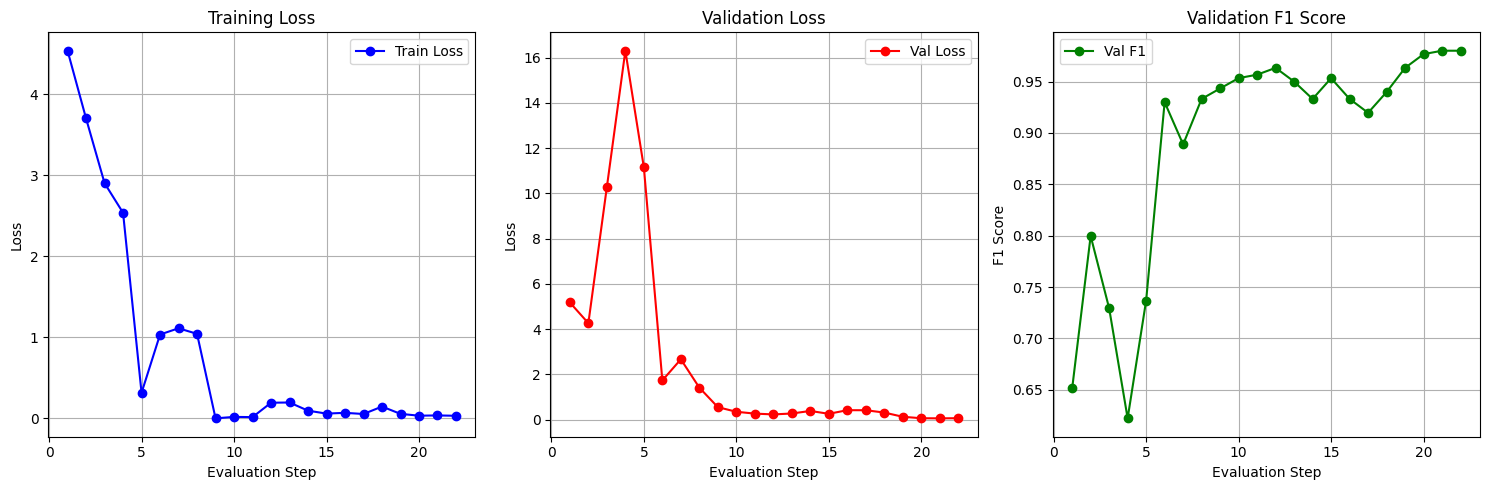

In [8]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    if not history["val_f1"]:
        print("No training history to plot")
        return
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    steps = range(1, len(history["train_loss"]) + 1)
    
    # Training loss
    axes[0].plot(steps, history["train_loss"], 'b-o', label='Train Loss')
    axes[0].set_title('Training Loss')
    axes[0].set_xlabel('Evaluation Step')
    axes[0].set_ylabel('Loss')
    axes[0].grid(True)
    axes[0].legend()
    
    # Validation loss
    axes[1].plot(steps, history["val_loss"], 'r-o', label='Val Loss')
    axes[1].set_title('Validation Loss')
    axes[1].set_xlabel('Evaluation Step')
    axes[1].set_ylabel('Loss')
    axes[1].grid(True)
    axes[1].legend()
    
    # F1 Score
    axes[2].plot(steps, history["val_f1"], 'g-o', label='Val F1')
    axes[2].set_title('Validation F1 Score')
    axes[2].set_xlabel('Evaluation Step')
    axes[2].set_ylabel('F1 Score')
    axes[2].grid(True)
    axes[2].legend()
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

# Prediction

In [9]:
# Load the test CSV for predictions
test_csv_path = "/kaggle/input/ai-vs-human-generated-dataset/test.csv"
test_df = pd.read_csv(test_csv_path)

# Define the base directory where images are stored
test_data_dir = "/kaggle/input/ai-vs-human-generated-dataset"

# Update image paths in the test dataframe
test_df['img_path'] = test_df['id'].apply(lambda x: os.path.join(test_data_dir, x))

In [10]:
%%time

# Initialize a list to store results
predictions = []

# Perform inference on test images
for idx, row in tqdm(test_df.iterrows(), total=len(test_df)):
    # if idx==100:
    #     break
    
    img_path = row['img_path']  # Path to the image
    id_ = row['id']
    try:
        # Open and preprocess image
        image = np.array(Image.open(img_path).convert("RGB"))
        input_tensor = val_transform(image=image)['image'].unsqueeze(0).to(device)  # Add batch dimension

        # Model prediction
        with torch.no_grad():
            outputs = model(input_tensor)
            predicted_label = torch.argmax(outputs, dim=-1).item()  # Get predicted class

        predictions.append((id_, predicted_label))
    except Exception as e:
        print(f"Error processing {img_path}: {e}")


100%|██████████| 5540/5540 [04:55<00:00, 18.72it/s]

CPU times: user 3min 36s, sys: 8.61 s, total: 3min 44s
Wall time: 4min 55s


In [11]:
# Create a DataFrame for submission
submission_df = pd.DataFrame(predictions, columns=["id", "label"])

# # Save to CSV for submission
submission_csv_path = "submission.csv"
submission_df.to_csv(submission_csv_path, index=False)
print(f"Submission file saved at {submission_csv_path}")

Submission file saved at submission.csv


In [12]:
value_counts = submission_df['label'].value_counts()
value_counts

label
0    4800
1     740
Name: count, dtype: int64

In [13]:
submission_df.head()

,id,label
0,test_data_v2/1a2d9fd3e21b4266aea1f66b30aed157.jpg,1
1,test_data_v2/ab5df8f441fe4fbf9dc9c6baae699dc7.jpg,0
2,test_data_v2/eb364dd2dfe34feda0e52466b7ce7956.jpg,0
3,test_data_v2/f76c2580e9644d85a741a42c6f6b39c0.jpg,0
4,test_data_v2/a16495c578b7494683805484ca27cf9f.jpg,0
